In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
import math
import csv
from PIL import Image
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.applications import VGG19
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime

Using TensorFlow backend.
c:\users\robotics\anaconda3\envs\faster_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\robotics\anaconda3\envs\faster_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\robotics\anaconda3\envs\faster_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\robotics\an

In [2]:
ratio = 4
channels = 3
HR_size = np.array([480,640])#
LR_size = HR_size // ratio
H_h = HR_size[0]
H_w = HR_size[1]
L_h = LR_size[0]
L_w = LR_size[1]

print(HR_size[0])
print(LR_size)

480
[120 160]


In [5]:
class DataLoader():
    def __init__(self):
        pass
#         self.ratio = ratio
#         self.HR_size = HR_size
#         self.LR_size = HR_size / ratio
#         self.H_h = HR_size[0]
#         self.H_w = HR_size[1]
#         self.L_h = LR_size[0]
#         self.L_h = LR_size[1]
        
    
    
    def load_data(self, batch_size = 1):
        files = glob.glob("../../images/train/*.png", recursive=True)
        batch_images = random.sample(files, batch_size)
    
        HR_images = []
        LR_images = []
    
        for img_path in batch_images:
            img = Image.open(img_path)

            HR_image = img.resize((H_w, H_h))  #(64, 64)
            LR_image = img.resize((L_w, L_h))
            HR_image = np.array(HR_image)
            #img_hr = (img_hr - 127.5) / 127.5
            LR_image = np.array(LR_image)
            #img_lr = (img_lr - 127.5) / 127.5

#             if not is_testing and np.random.random() < 0.5:
#                 img_hr = np.fliplr(img_hr)
#                 img_lr = np.fliplr(img_lr)

            HR_images.append(HR_image)
            LR_images.append(LR_image)
        
        HR_images = np.array(HR_images) / 127.5 - 1
        LR_images = np.array(LR_images) / 127.5 - 1
        
        return HR_images, LR_images

#------------------------------------------------------------------#
  
#------------------------------------------------------------------#

class predDataLoader():          
    def load_data(self, batch_size, counter):
        random.seed(counter)
        np.random.seed(counter)

        files = glob.glob("../../images/test/*.png", recursive=True)
        batch_images = random.sample(files, batch_size)

        imgs_or = []
        for img_path in batch_images:
            img = Image.open(img_path)

            img_or = np.array(img)
            imgs_or.append(img_or)

        imgs_or = np.array(imgs_or) / 127.5 - 1.

        return imgs_or
    
    
#------------------------------------------------------------------#
  
#------------------------------------------------------------------#

class SRGAN():
    def __init__(self):
        
        # Input shape
#         self.channels = 3
#         self.lr_height = 288                 # Low resolution height
#         self.lr_width = 384                  # Low resolution width
#         self.lr_shape = (self.lr_height, self.lr_width, self.channels)
#         resLevel = 2 #
#         self.hr_height = self.lr_height*resLevel  # High resolution height
#         self.hr_width = self.lr_width*resLevel     # High resolution width
#         self.hr_shape = (self.hr_height, self.hr_width, self.channels)

        #残差ブロックの数
        # Number of residual blocks in the generator
        self.n_residual_blocks = 16 #

        optimizer = Adam(0.0002, 0.5)

        #img_hrの特徴量をVGG19で算出する
        # We use a pre-trained VGG19 model to extract image features from the high resolution
        # and the generated high resolution images and minimize the mse between them
        self.VGG = self.build_vgg()
        self.VGG.trainable = False
        self.VGG.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        
        #データはここで読み込まれる
        # Configure data loader
        #self.dataset_name = 'img_align_celeba'
        self.data_loader = DataLoader()
        self.pred_data_loader = predDataLoader()

        #Dのサイズ
        # Calculate output shape of D (PatchGAN)
        patchH = int(H_h / 2**4) #
        patchW = int(H_w / 2**4) #
        self.disc_patch = (patchH, patchW, 1) 

        #DとGのチャンネル設定
        # Number of filters in the first layer of G and D
        self.gf = 60 #gf
        self.df = 60 #df
        #Dビルドとコンパイル
        # Build and compile the discriminator
        self.Discriminator = self.build_discriminator()
        self.Discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #Gのビルド
        # Build the generator
        self.Generator = self.build_generator()

        # High res. and low res. images
        HR_image = Input(shape = (H_h, H_w, channels))
        LR_image = Input(shape = (L_h, L_w, channels))

        #Gで生成されたhrのimg
        # Generate high res. version from low res.
        SR_image = self.Generator(LR_image)

        #hrのimgの特徴量の算出
        # Extract image features of the generated img
        SR_features = self.VGG(SR_image)

        # For the combined model we will only train the generator
        self.Discriminator.trainable = False

        #学習モデルコンパイル
        # Discriminator determines validity of generated high res. images
        validity = self.Discriminator(SR_image)

        self.combined = Model([LR_image, HR_image], [validity, SR_features])
        self.combined.compile(loss=['binary_crossentropy', 'mse'],
                              loss_weights=[1e-3, 1],
                              optimizer=optimizer)
        
    #------------------------------------------------------------------#
    
    def build_vgg(self):
        """
        Builds a pre-trained VGG19 model that outputs image features extracted at the
        third block of the model
        """
        VGG = VGG19(weights="imagenet")
        # Set outputs to outputs of last conv. layer in block 3
        # See architecture at: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
        VGG.outputs = [VGG.layers[9].output]

        img = Input(shape = (H_h, H_w, channels))

        # Extract image features
        img_features = VGG(img)

        return Model(img, img_features)
    
    #------------------------------------------------------------------#
    
    #Generator の実装
    def build_generator(self):

        #残差ブロックの中身
        def residual_block(layer_input, n_filters):
            """Residual block described in paper"""
            d = Conv2D(n_filters, kernel_size=3, strides=1, padding='same')(layer_input)
            d = Activation('relu')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Conv2D(n_filters, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d

        #解像度を2倍にするUpSampling
        def deconv2d(layer_input):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input) #
            u = Conv2D(120, kernel_size=3, strides=1, padding='same')(u) #
            u = Activation('relu')(u)
            return u

        # Low resolution image input
        img_lr = Input(shape = (L_h, L_w, channels))

        # Pre-residual block
        c1 = Conv2D(60, kernel_size=9, strides=1, padding='same')(img_lr) #
        c1 = Activation('relu')(c1)

        # Propogate through residual blocks
        r = residual_block(c1, self.gf)
        for _ in range(self.n_residual_blocks - 1):
            r = residual_block(r, self.gf)

        #去の残差ブロックと組み合わせる
        # Post-residual block
        c2 = Conv2D(60, kernel_size=3, strides=1, padding='same')(r) #
        c2 = BatchNormalization(momentum=0.8)(c2)
        c2 = Add()([c2, c1])

        # Upsampling
        n = ratio
        while(n % 2 == 0):
            c2 = deconv2d(c2)
            n = n // 2

        # Generate high resolution output
        gen_hr = Conv2D(channels, kernel_size=9, strides=1, padding='same', activation='tanh')(c2)

        return Model(img_lr, gen_hr)
    
    
    #------------------------------------------------------------------#
    
    #Discriminator の実装
    def build_discriminator(self):

        
        def d_block(layer_input, filters, strides=1, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        # Input img
        d0 = Input(shape = (H_h, H_w, channels))
        #畳み込み層、チャンネル数を最終的に16倍に
        d1 = d_block(d0, self.df, bn=False)
        d2 = d_block(d1, self.df, strides=2)
        d3 = d_block(d2, self.df*2)
        d4 = d_block(d3, self.df*2, strides=2)
        d5 = d_block(d4, self.df*4)
        d6 = d_block(d5, self.df*4, strides=2)
        d7 = d_block(d6, self.df*8)
        d8 = d_block(d7, self.df*8, strides=2)
        #この時点で画像サイズ1/16
        d9 = Dense(self.df*16)(d8)
        d10 = LeakyReLU(alpha=0.2)(d9)
        validity = Dense(1, activation='sigmoid')(d10)

        return Model(d0, validity)
    
    
    #------------------------------------------------------------------#
    
    
    #学習
    def train(self, epochs, batch_size, sample_interval=100):

        start_time = datetime.datetime.now()
        psnr_file = open('psnr.csv' , 'w+')
        psnr_file.close()
        

        for epoch in range(epochs):

            # ----------------------
            #  Train Discriminator
            # ----------------------

            # Sample images and their conditioning counterparts
            HR_images, LR_images = self.data_loader.load_data(batch_size)

            # From low res. image generate high res. version
            SR_images = self.Generator.predict(LR_images)

            valid = np.ones((batch_size,) + self.disc_patch)#教師データ
            fake = np.zeros((batch_size,) + self.disc_patch)#教師データ

            #Dのloss
            # Train the discriminators (original images = real / generated = Fake)
            d_loss_real = self.Discriminator.train_on_batch(HR_images, valid)
            d_loss_fake = self.Discriminator.train_on_batch(SR_images, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ------------------
            #  Train Generator
            # ------------------

            # Sample images and their conditioning counterparts
           
            #HR_images, LR_images = self.data_loader.load_data(batch_size)

            # The generators want the discriminators to label the generated images as real
            valid = np.ones((batch_size,) + self.disc_patch)

            # Extract ground truth image features using pre-trained VGG19 model
            image_features = self.VGG.predict(HR_images)

            # Train the generators
            g_loss = self.combined.train_on_batch([LR_images, HR_images], [valid, image_features])

            elapsed_time = datetime.datetime.now() - start_time
            # Plot the progress
            print ("%d time: %s" % (epoch, elapsed_time))

            # If at save interval => save generated image samples
            if (epoch + 1) % sample_interval == 0:
                HR_images, LR_images, SR_images = self.sample_images(epoch+1, HR_images, LR_images, SR_images, batch_size)
                self.Generator.save_weights('srg_weight.h5')
                
                cv2.imwrite("../../images/images/{}_HR_image.png".format(epoch+1),HR_images[0])
                cv2.imwrite("../../images/images/{}_LR_image.png".format(epoch+1),LR_images[0])
                cv2.imwrite("../../images/images/{}_SR_image.png".format(epoch+1),SR_images[0])
                
                
    #------------------------------------------------------------------#
            
            
    
    #------------------------------------------------------------------#
    
    
    def sample_images(self, epoch, imgs_hr, imgs_lr, fake_hr, n):
        def denormalize(input_data):
            input_data = (input_data + 1) * 127.5
            return input_data.astype(np.uint8)
        

        imgs_lr = denormalize(imgs_lr)
        fake_hr = denormalize(fake_hr)
        imgs_hr = denormalize(imgs_hr)

        def psnr_calc(img1: np.ndarray, img2: np.ndarray, upscaling=8):
            def convert(img):
                return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            def extract_y(image: np.ndarray) -> np.ndarray:
                if image.ndim == 2:
                    return image
                image = image.astype(np.int32)
                return ((image[:, :, 2] * 65.481 / 255.
                          + image[:, :, 1] * 128.553 / 255.
                          + image[:, :, 0] * 24.966 / 255.) + 16).astype(np.int32)


            def psnr(img1, img2):
                mse = np.mean((img1 - img2) ** 2)
                if mse == 0:
                    return 100
                PIXEL_MAX = 255.0
                return 10 * math.log10(PIXEL_MAX * PIXEL_MAX / mse)
  
            img1_conv=convert(img1)
            img2_conv=convert(img2)
  
            # BGR -> YCrCb
            # 画像はcv2.imreadで読まれている前提 [0, 255]
            y1 = extract_y(img1_conv)
            y2 = extract_y(img2_conv)
            # 周囲のcropping
            # assert y1.shape == y2.shape
            h, w = y1.shape
            cr = upscaling
            cropped_y1 = y1[cr:h - cr, cr:w - cr].astype(np.float64)
            cropped_y2 = y2[cr:h - cr, cr:w - cr].astype(np.float64)

            # psnr
            psnr_val = psnr(cropped_y1, cropped_y2)
            return psnr_val
        
        
        # size=(480,480)
        psnr = 0
        print(psnr_calc(imgs_hr[0], fake_hr[0]))
        for i in range(n):
            psnr += psnr_calc(imgs_hr[i],fake_hr[i])
        
        m_psnr = psnr / n
        print(m_psnr)
        data =[epoch,m_psnr]
        psnr_file = open('psnr.csv' , 'a')
        writer = csv.writer(psnr_file, lineterminator='\n')  
        writer.writerow(data)
        psnr_file.close()
            
        return imgs_hr, imgs_lr, fake_hr
    

In [6]:
if __name__ == '__main__':
    gan = SRGAN()
    #gan = load_model("srg_weight.h5")
    gan.train(epochs=500, batch_size=1, sample_interval=50)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
0 time: 0:00:21.259765
1 time: 0:00:21.850808
2 time: 0:00:22.436340
3 time: 0:00:23.004990
4 time: 0:00:23.588974
5 time: 0:00:24.176509
6 time: 0:00:24.762041
7 time: 0:00:25.332717
8 time: 0:00:25.919250
9 time: 0:00:26.507290
10 time: 0:00:27.067448
11 time: 0:00:27.663068
12 time: 0:00:28.252108
13 time: 0:00:28.839622
14 time: 0:00:29.408176
15 time: 0:00:29.992707
16 time: 0:00:30.578240
17 time: 0:00:31.129914
18 time: 0:00:31.729563
19 time: 0:00:32.317097
20 time: 0:00:32.901660
21 time: 0:00:33.494005
22 time: 0:00:34.090051
23 time: 0:00:34.684096
24 time: 0:00:35.254518
25 time: 0:00:35.843386
26 time: 0:00:36.439929
27 time: 0:00:37.032288
28 time: 0:00:37.627061
29 time: 0:00:38.223603
30 time: 0:00:38.812138
31 time: 0:00:39.398173
32 time: 0:00:39.995715
33 time: 0:00:40.594260
34 time: 0:00:41.161105
35 time: 0:00:41.752797
36 time: 0:00:42.340903
37 t

309 time: 0:03:35.726254
310 time: 0:03:36.280625
311 time: 0:03:36.834161
312 time: 0:03:37.389294
313 time: 0:03:37.931116
314 time: 0:03:38.492404
315 time: 0:03:39.050991
316 time: 0:03:39.620501
317 time: 0:03:40.192959
318 time: 0:03:40.759376
319 time: 0:03:41.334198
320 time: 0:03:41.903271
321 time: 0:03:42.449645
322 time: 0:03:42.993377
323 time: 0:03:43.558997
324 time: 0:03:44.111413
325 time: 0:03:44.662567
326 time: 0:03:45.217095
327 time: 0:03:45.768361
328 time: 0:03:46.323435
329 time: 0:03:46.874869
330 time: 0:03:47.426248
331 time: 0:03:47.977492
332 time: 0:03:48.532901
333 time: 0:03:49.084136
334 time: 0:03:49.635570
335 time: 0:03:50.199779
336 time: 0:03:50.772190
337 time: 0:03:51.356837
338 time: 0:03:51.918070
339 time: 0:03:52.498970
340 time: 0:03:53.048757
341 time: 0:03:53.600033
342 time: 0:03:54.150286
343 time: 0:03:54.701819
344 time: 0:03:55.282352
345 time: 0:03:55.876619
346 time: 0:03:56.466082
347 time: 0:03:57.034834
348 time: 0:03:57.624912


In [16]:
with open('psnr.csv') as f:
    reader = csv.reader(f)
    psnr_array1=[]
    psnr_array2=[]
    epoch_array1=[]
    epoch_array2=[]
    cnt=1
    for row in reader:
        if(cnt%2 is 1):
          psnr_array1.append(float(row[1]))
          epoch_array1.append(int(row[0]))
        else:
          psnr_array2.append(float(row[1]))
          epoch_array2.append(int(row[0]))
        cnt+=1

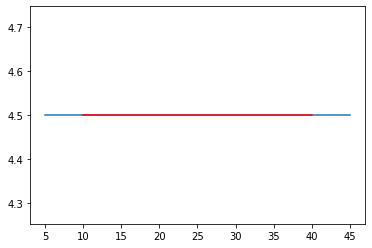

In [17]:
import matplotlib.pyplot as plt
plt.plot(epoch_array1, psnr_array1)
plt.plot(epoch_array2, psnr_array2,color='red')

In [7]:
with open('psnr.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        print(row)

['50', '20.412173358030927']
['50', '15.18460843679263']
['100', '21.155173524735147']
['100', '22.088970373943063']
['150', '16.688180560370192']
['150', '16.16855562760126']
['200', '18.057474661808378']
['200', '16.297320147013348']
['250', '22.370358139880075']
['250', '17.609617081759897']
['300', '16.17673981514797']
['300', '15.901844875332857']
['350', '16.647917310324704']
['350', '18.590832767878812']
['400', '20.303747792973134']
['400', '16.801384368074487']
['450', '17.95323828273801']
['450', '22.840539709577286']
['500', '22.488590354046035']
['500', '18.327863422218165']


In [8]:
class Generate(SRGAN):
    def generate(self, batch_size=1, sample_interval=50):
        BATCH_SIZE=1
        ite=10000
        def denormalize(input_data):
            input_data = (input_data + 1) * 127.5
            return input_data.astype(np.uint8)
            
        self.generator = self.build_generator()
        g = self.generator
        g.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
        g.load_weights('srg_weight.h5')
        for i in range(10):
            noise = np.random.uniform(size=[BATCH_SIZE, 480*640*3], low=-1.0, high=1.0)
            imgs_or = self.pred_data_loader.load_data(batch_size=1,counter=i)
            # imgs_hr, imgs_or = self.data_loader.load_data(batch_size=BATCH_SIZE,is_testing=True)

            plt.imshow(denormalize(imgs_or[0]))
            plt.pause(1)
            noise=imgs_or.reshape(BATCH_SIZE,480,640,3)
            generated_images = g.predict(noise)
            plt.imshow(denormalize(generated_images[0]))
            plt.pause(1)
            p_im=Image.fromarray(denormalize(generated_images[0]))
            p_im.save('../../images/output/p_im_{}.png'.format(i))
            # plt.imshow(p_im.resize((120,120)), Image.LANCZOS)

            print(i)
        # os.makedirs(os.path.join(".", "images"), exist_ok=True)
        # image.save("./images/%s%d.png" % (ite,i))            

    def combine_images(generated_images, cols=5, rows=5):
        shape = generated_images.shape
        h = shape[1]
        w = shape[2]
        image = np.zeros((rows * h,  cols * w, 3))
        for index, img in enumerate(generated_images):
            if index >= cols * rows:
                break
            i = index // cols
            j = index % cols
            image[i*h:(i+1)*h, j*w:(j+1)*w, :] = img[:, :, :]
        image = image * 127.5 + 127.5
        image = Image.fromarray(image.astype(np.uint8))
        
        return image

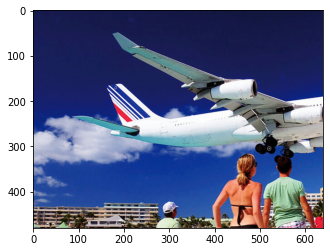

ValueError: Error when checking : expected input_27 to have shape (None, 120, 160, 3) but got array with shape (1, 480, 640, 3)

In [19]:
if __name__ == '__main__':
    gene = Generate()
    gene.generate(batch_size=1, sample_interval=1000)